In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Deconvolution2D, Reshape, Concatenate
import keras

from keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [8]:
import pickle

In [9]:
tf.compat.v1.disable_eager_execution()

In [10]:
batch_size = 128

In [11]:
#Load labeled data and divide into training and test sets
labels = pd.read_csv("labels.csv",index_col=0)
selected_labels = ["is_bended","is_violet","has_rost_body","short","thick","thin"]
labels = labels[selected_labels].values

images = np.load("palette_as_rgb.npy")
images = images[::3]

#Padding is required as the net does not work with arbitrary shapes due to problems with reconstructing the same
#shape in deconvolution layers (Deconvolution increases size by factor 2 or 3 or .. i.e. by an integer factor)
images = np.pad(images[:,:], pad_width=((0,0),(1,1),(0,0),(0,0)), mode='constant', constant_values=0)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [12]:
images = None#free some memory

In [13]:
# Load unlabeled and generate array of nan as labels (analogously to x_train, y_train)
unlabeled = np.load("unlabeled.npy")
unlabeled = unlabeled[::3]
unlabeled = np.pad(unlabeled[:,:], pad_width=((0,0),(1,1),(0,0),(0,0)), mode='constant', constant_values=0)
unlabeled = unlabeled.astype('float32') / 255

unlabeled_labels_shape = [len(unlabeled)]
unlabeled_labels_shape.extend(list(y_train.shape)[1:])
unlabeled_labels = np.ndarray(unlabeled_labels_shape)
unlabeled_labels.fill(-1)

In [14]:
def interlace_unlabeled_batches(x_train,y_train,unlabeled,unlabeled_labels):
    # Divide into batches
    x_train = np.split(x_train, [batch_size+x*batch_size for x in range(len(x_train)//batch_size)])
    x_train = x_train[:-1]#discard incomplete batch
    y_train = np.split(y_train, [batch_size+x*batch_size for x in range(len(y_train)//batch_size)])
    y_train = y_train[:-1]#discard incomplete batch

    # Divide into batches
    unlabeled = np.split(unlabeled, [batch_size+x*batch_size for x in range(len(unlabeled)//batch_size)])
    unlabeled = unlabeled[:-1]#discard incomplete batch
    unlabeled_labels = np.split(unlabeled_labels, [batch_size+x*batch_size for x in range(len(unlabeled_labels)//batch_size)])
    unlabeled_labels = unlabeled_labels[:-1]#discard incomplete batch

    # Zip them [with_label_batch, without_label_batch, with_label_batch ...]
    min_length = np.min([len(unlabeled_labels),len(y_train)])
    x_train1 = np.array(list(zip(unlabeled[:min_length],x_train[:min_length])))
    y_train1 = np.array(list(zip(unlabeled_labels[:min_length],y_train[:min_length])))

    #Reshape such that there are batch_size times unlabeled examples then batch_time_size labeled examples etc.
    y_train1 = y_train1.reshape([y_train1.shape[0]*y_train1.shape[1],y_train1.shape[2],y_train1.shape[3]])
    y_train1 = y_train1.reshape([y_train1.shape[0]*y_train1.shape[1],y_train1.shape[2]])

    new_shape = [x_train1.shape[0]*x_train1.shape[1]]#Merge first two dimensions
    new_shape.extend(list(x_train1.shape)[2:])
    x_train1 = x_train1.reshape(new_shape)
    new_shape = [x_train1.shape[0]*x_train1.shape[1]]#Merge first two dimensions
    new_shape.extend(list(x_train1.shape)[2:])
    x_train1 = x_train1.reshape(new_shape)
    return x_train1, y_train1

In [15]:
x_train, y_train = interlace_unlabeled_batches(x_train,y_train,unlabeled,unlabeled_labels)

In [16]:
# Shapes
input_shape = np.array(x_train.shape)
output_shape = input_shape
shape = np.zeros(4, dtype=np.int32)
shape[0] = -1
shape[-1] = 32
shape[1:3] = (output_shape[1:3]//2)//2#Such that after application of filters the desired output shape is achieved 
input_shape = input_shape[1:]
output_shape = output_shape[1:]

labels_shape = y_train.shape[1]

# network parameters
kernel_size = 3
filters = 16
latent_dim = 2
bypass_dim = 1

In [17]:
# reparameterization trick, instead of sampling from Q(z|X), sample eps = N(0,I), then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [18]:
inputs = Input(shape=input_shape, name='encoder_input')
label_inputs = Input(shape=(labels_shape,), name='label_inputs')

conv_layer0 = Conv2D(32, kernel_size=(2, 2),activation='relu',input_shape=input_shape)(inputs)
conv_layer1 = Conv2D(32, (3, 3), activation='relu')(conv_layer0)
maxpool_layer0 = MaxPooling2D(pool_size=(2, 2))(conv_layer1)
conv_layer2 = Conv2D(32, (3, 3), activation='relu')(maxpool_layer0)
maxpool_layer1 = MaxPooling2D(pool_size=(2, 2))(conv_layer2)
dropout_layer0 = Dropout(0.25)(maxpool_layer1)
flatten_layer0 = Flatten()(dropout_layer0)
dense_layer0 = Dense(64, activation='relu')(flatten_layer0)
x = Dropout(0.5)(dense_layer0)

label_layer = Dense(labels_shape, name='label_layer')(x)
label_layer_sigmoid = Lambda(lambda x: tf.sigmoid(x), name='label_layer_sigmoid')(label_layer)
error_layer = Lambda(lambda x: tf.abs(x[0]-x[1]))([label_layer_sigmoid,label_inputs])
dummy_layer = Lambda(lambda x: x*0, name='dummy_layer')(error_layer)#To keep the graph connected

bypass_layer = Dense(bypass_dim, name='bypass_layer')(x)
#error_layer = Lambda(lambda x: -tf.math.log(1. / x - 1.), output_shape=(latent_dim,), name='label_layer_logit_of_sigmoid')(error_layer)
concatenated = Concatenate()([dummy_layer,  label_layer, bypass_layer])

z_mean = Dense(latent_dim, name='z_mean')(concatenated)
z_log_var = Dense(latent_dim, name='z_log_var')(concatenated)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,activation='relu',strides=2,padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=input_shape[-1], kernel_size=kernel_size, activation='sigmoid',padding='same',name='decoder_output')(x)


# instantiate encoder model
encoder = Model([inputs,label_inputs], [z_mean, z_log_var, z, label_layer_sigmoid], name='encoder')
encoder.summary()

# instantiate decoder model
decoder = Model([latent_inputs], outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder([inputs,label_inputs])[2])
vae = Model(inputs=[inputs,label_inputs], outputs=[outputs], name='vae')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 136, 36, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 135, 35, 32)  416         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 133, 33, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 66, 16, 32)   0           conv2d_2[0][0]                   
___________

In [19]:
from keras.utils.vis_utils import plot_model

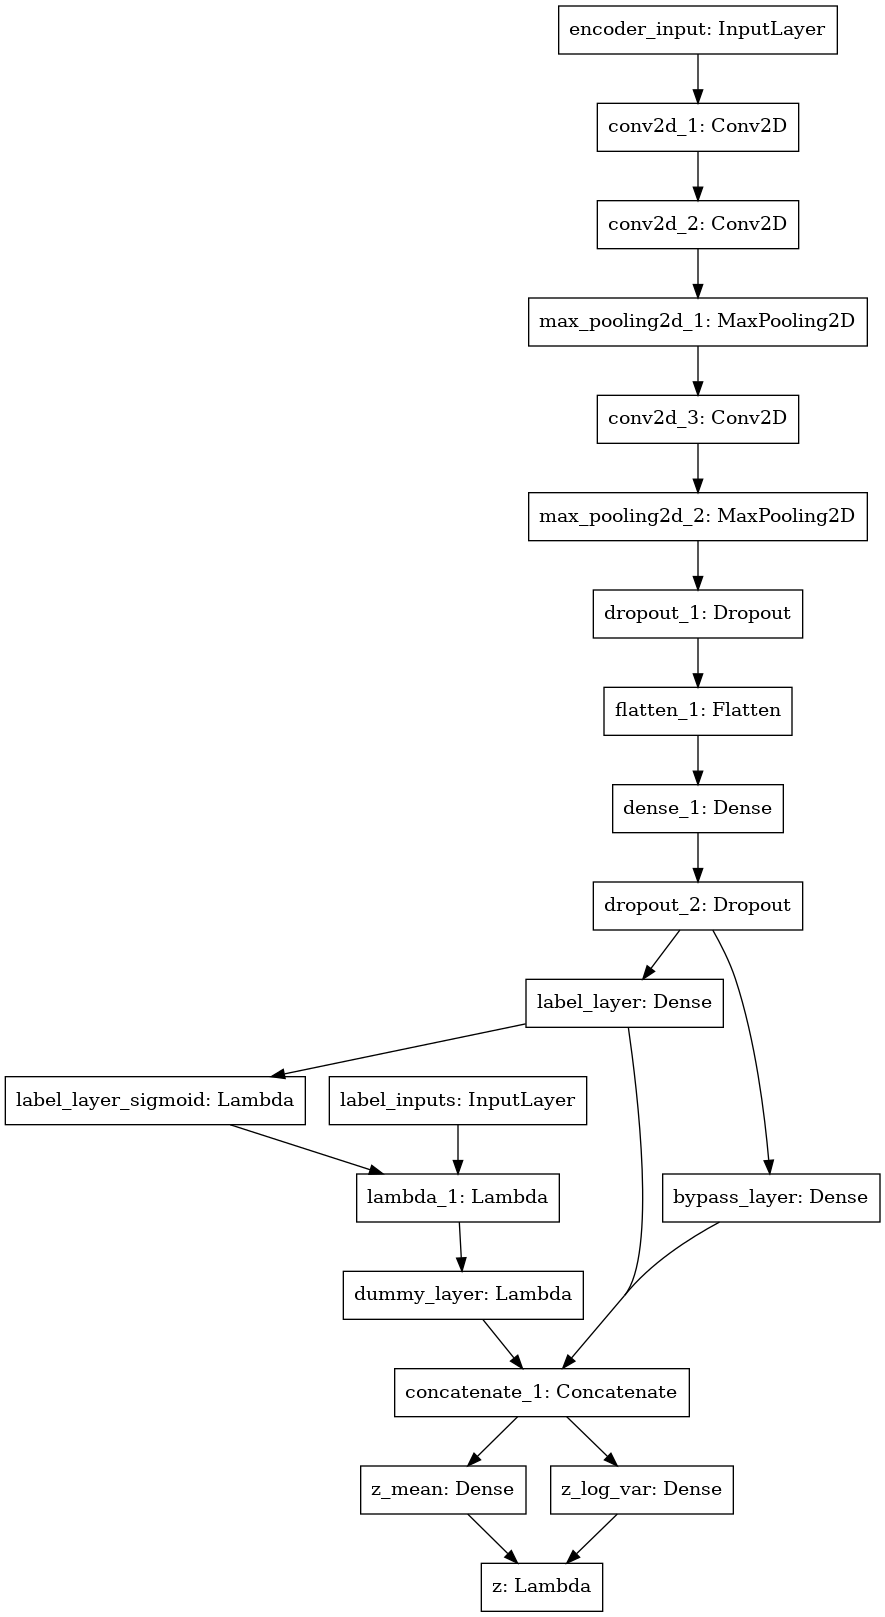

In [20]:
plot_model(encoder, show_layer_names=True)

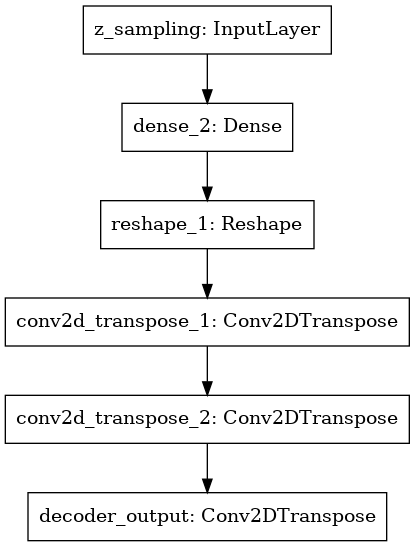

In [46]:
plot_model(decoder, show_layer_names=True)

In [21]:
def mse(y_true, y_pred):
    #y_true = K.print_tensor(y_true, message='y_true = ')
    if not K.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [22]:
def check_for_nan(label_inputs):
    #label_inputs = K.print_tensor(label_inputs, message='contains_nan = ')
    contains_nan = tf.reduce_any(tf.math.equal(label_inputs,-1))
    #contains_nan = K.print_tensor(contains_nan, message='contains_nan = ')
    return contains_nan

In [23]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] *  input_shape[1] * input_shape[2]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

contains_nan = check_for_nan(label_inputs)
class_loss = 100+10*K.mean(error_layer)*vae_loss#make the class loss scale with the vae_loss
combined_loss = class_loss + vae_loss
final_loss = tf.cond(contains_nan,lambda: vae_loss,lambda: combined_loss)

In [24]:
vae.add_loss(final_loss)
vae.compile(optimizer='rmsprop')

/home/elerator/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [34]:
epochs = 1
history = vae.fit([x_train,y_train],epochs=epochs,batch_size=batch_size,verbose=1,shuffle=False)#Do not shuffle!!!

Epoch 1/1
19968/19968 [==============================] - 383s 19ms/step - loss: 377.6293


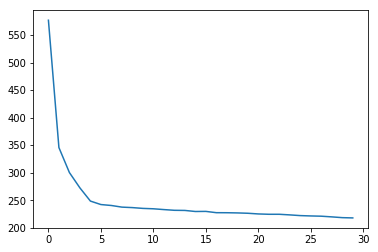

In [22]:
plt.plot(history.history["loss"])
#pickle.dump(history.history["loss"],open("semi_supervised_whole_loss.pkl", "wb"))

In [23]:
#vae.save_weights('semi_supervised_whole.h5')
#vae.load_weights("semi_supervised_whole.h5")

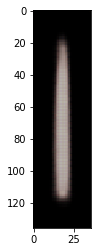

In [35]:
plt.imshow(decoder.predict(np.array([[2,2]]))[0,:,:,:])

In [36]:
def plot_results(models, data, batch_size=128, model_name="convolutional_vae_large"):
    """Plot asparagus pieces as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "convolutional_vae.png")
    z_mean, _, _, _ = encoder.predict([x_test,y_test], batch_size=batch_size)
    
    #fig, ax = plt.subplots(1,2,figsize=(16,9))#plt.figure(figsize=(20, 20))
    fig = plt.figure(figsize=(18,15))
    gs = fig.add_gridspec(2, 4)
    ax_img = fig.add_subplot(gs[:,-1])
    

    #plt.figure(figsize=(12, 10))
    i = 0
    attributes = list(y_test.keys())[:]
    attribute_labels = ["is_bended","is_violet","has_rost_body","short","thick","thin"]
    
    for y in range(2):
        for x in range(3): 
            current_attribute = attributes[i]
            scatter_ax = fig.add_subplot(gs[y,x])
            scatter_ax.set_title(attribute_labels[i])
            scatter_ax.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test[current_attribute]==0, marker = "x")
            #plt.colorbar()
            scatter_ax.set_xlabel("z [0]")
            scatter_ax.set_ylabel("z [1]")
            i += 1
    
    # display a 30x30 2D manifold of digits
    n = 10
    digit_size = 28
    figure = np.zeros((input_shape[0] * n, input_shape[1] * n,3))# Accumulate in RGB Image Tensor
    
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            figure[i * input_shape[0]: (i + 1) * input_shape[0],
                   j * input_shape[1]: (j + 1) * input_shape[1],:] = x_decoded

    start_range_y = input_shape[0] // 2
    start_range_x = input_shape[1] // 2

    end_range_y = n * input_shape[0] + start_range_y + 1
    end_range_x = n * input_shape[1] + start_range_x + 1

    pixel_range_y = np.arange(start_range_y, end_range_y, input_shape[0])
    pixel_range_x = np.arange(start_range_x, end_range_x, input_shape[1])
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    ax_img.set_xticks(pixel_range_x)
    ax_img.set_xticklabels(sample_range_x)
    ax_img.set_title("Decoded Images (Mapping from latent space)")


    ax_img.set_yticks(pixel_range_y)
    ax_img.set_yticklabels(labels=sample_range_y)
    ax_img.set_xlabel("z [0]")
    ax_img.set_ylabel("z [1]")
    ax_img.imshow(figure, cmap='Greys_r')
    fig.savefig(filename)
    fig.show()

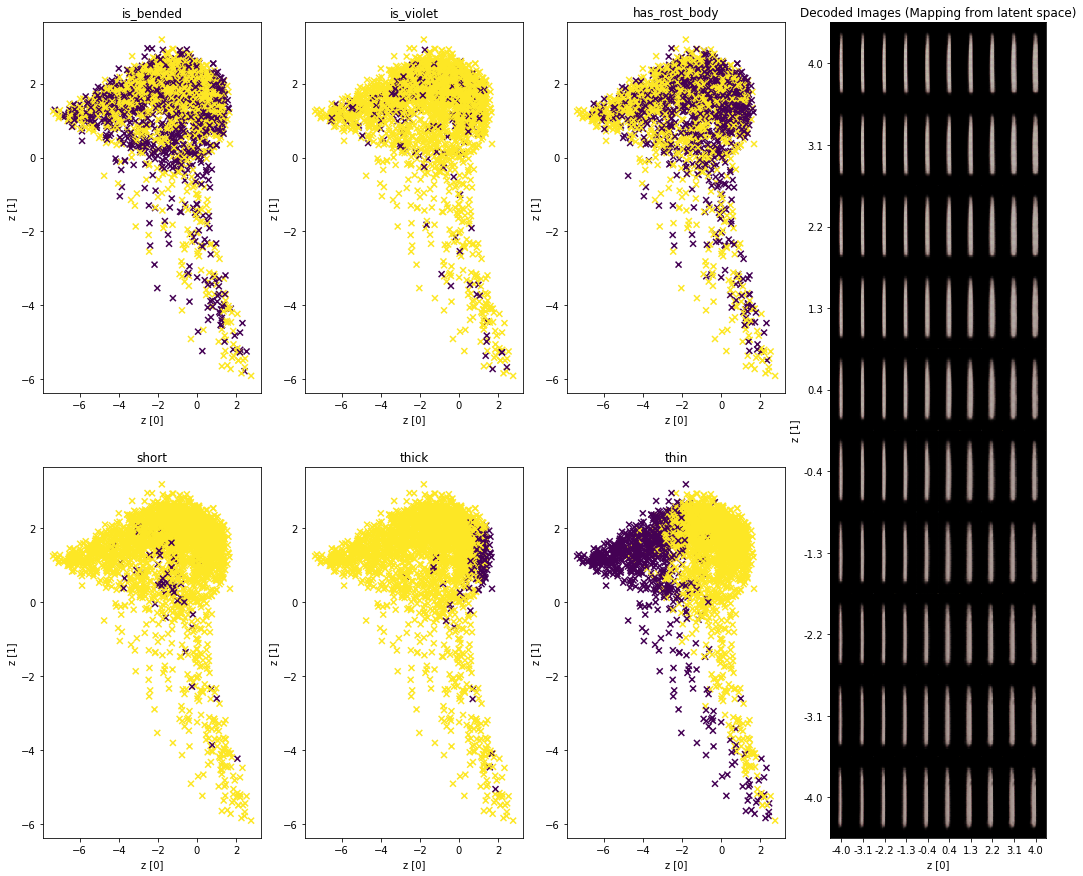

In [37]:
models = (encoder, decoder)
y_test = pd.DataFrame(y_test, columns=["is_bended","is_violet","has_rost_body","short","thick","thin"])
data = (x_test, y_test)
plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

In [38]:
def get_confusion_matrices(y_pred,y_test,bias=False, additional_measures=False):
    #Calculate confusion matrix
    if bias == False:
        bias = .5
    y_pred = y_pred > bias
    y_test = pd.DataFrame(y_test, dtype=np.int32)
    y_pred = np.array(y_pred, dtype=np.int32)
    y_test = pd.DataFrame(y_test)
    false_negatives = np.sum(np.logical_and(y_test == 1,y_pred==0),axis=0)#y_test is 1 while y_pred did not indicate
    false_positives = np.sum(np.logical_and(y_test == 0,y_pred==1),axis=0)#y_test is 0 while y_pred say it was 1
    true_positives = np.sum(np.logical_and(y_test == 1,y_pred==1),axis=0)#both indicate 1
    true_negatives = np.sum(np.logical_and(y_test == 0,y_pred==0),axis=0)#both indicate 0
    summary = pd.DataFrame()
    summary['False positive'] = false_positives
    summary['False negative'] = false_negatives
    summary['True positive'] = true_positives
    summary['True negative'] = true_negatives
    summary = pd.DataFrame(summary)
    print(summary.sum(axis=1)[0])
    summary_percent = (summary/summary.sum(axis=1)[0])
    if additional_measures:
        #summary_percent['Accuracy'] = summary_percent['True positive'] + summary_percent['True negative']
        summary_percent['Sensitivity'] = summary_percent['True positive']/(summary_percent['True positive']+summary_percent['False negative'])
        summary_percent['Specificity'] = summary_percent['True negative']/(summary_percent['True negative']+summary_percent['False positive'])

    return summary, summary_percent

In [39]:
#The numbers do not add up to 100% how is that possible?

In [40]:
label_predictions = encoder.predict([x_test,y_test])[-1]

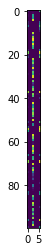

In [42]:
plt.imshow(label_predictions[:100])

In [43]:
conf = get_confusion_matrices(label_predictions,y_test,.5,True)[1]

2606


In [48]:
conf.round(2)

,False positive,False negative,True positive,True negative,Sensitivity,Specificity
is_bended,0.04,0.37,0.04,0.55,0.10,0.94
is_violet,0.00,0.08,0.00,0.92,0.00,1.00
has_rost_body,0.14,0.27,0.20,0.39,0.42,0.73
short,0.00,0.02,0.00,0.98,0.00,1.00
thick,0.00,0.07,0.00,0.93,0.00,1.00
thin,0.00,0.14,0.16,0.70,0.54,0.99


In [83]:
len(y_test["thick"])

2606

In [84]:
sum(y_test["thick"])

172

In [47]:
print(conf.round(2).to_latex(index=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  False positive &  False negative &  True positive &  True negative &  Sensitivity &  Specificity \\
\midrule
is\_bended     &            0.04 &            0.37 &           0.04 &           0.55 &         0.10 &         0.94 \\
is\_violet     &            0.00 &            0.08 &           0.00 &           0.92 &         0.00 &         1.00 \\
has\_rost\_body &            0.14 &            0.27 &           0.20 &           0.39 &         0.42 &         0.73 \\
short         &            0.00 &            0.02 &           0.00 &           0.98 &         0.00 &         1.00 \\
thick         &            0.00 &            0.07 &           0.00 &           0.93 &         0.00 &         1.00 \\
thin          &            0.00 &            0.14 &           0.16 &           0.70 &         0.54 &         0.99 \\
\bottomrule
\end{tabular}

